## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

In [44]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [45]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from fastai_extensions import *

In [46]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [47]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [48]:
data_dir = Path('data')
data_04 = Path('data_04')

In [49]:
qc_path=data_dir/'processing/model_confusion_qc/'

In [50]:
MODEL_NAME='bg_const'
tfm_name='cutout'

In [51]:
NB_NUM='03_28'

In [52]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 004fa2d0, DATE: 20191203


In [53]:
SUB_NUM='30'

In [54]:
img_size=256
bs=128
background='constant'

In [55]:
train_images=data_04/f'train/rotated/clipped/constant/{img_size}'
test_images=data_04/f'test/rotated/clipped/constant/{img_size}'

In [56]:
train_names = get_image_files(train_images)

In [57]:
test_names = get_image_files(test_images)

In [58]:
dfl=[]
for i in range(5):
    df=pd.read_csv(qc_path/f'03_28-0c79e3be_rz-s2-r{i}-20191201_result.csv')
    dfl.append(df)
df=pd.concat(dfl)

In [59]:
dfl=[]
for i in range(5):
    df=pd.read_csv(qc_path/f'03_28-0c79e3be_rz-s2-r{i}-20191201_preds.csv')
    dfl.append(df)
dfp=pd.concat(dfl)

In [60]:
dfp.head()

,Unnamed: 0,id,pred,loss,model
0,0,7a2d1320_256_bgconstant,concrete_cement,7.26,03_28-0c79e3be_rz-s2-r0-20191201
1,1,7a2d1320_zoom,concrete_cement,6.72,03_28-0c79e3be_rz-s2-r0-20191201
2,2,7a2d1320_256_wrap,concrete_cement,6.67,03_28-0c79e3be_rz-s2-r0-20191201
3,3,7a2d1320_256_reflect,concrete_cement,6.22,03_28-0c79e3be_rz-s2-r0-20191201
4,4,7a2dcf7c_256_reflect,irregular_metal,5.94,03_28-0c79e3be_rz-s2-r0-20191201


In [61]:
dfp.drop(columns=['Unnamed: 0'],inplace=True)

In [62]:
df_gold = pd.read_csv(data_dir / 'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')
df_gold.drop(columns=['target'], inplace=True)
df_gold = df_gold[['id', 'roof_material', 'verified', 'country', 'region']]

In [63]:
df_gold.head()

,id,roof_material,verified,country,region
0,7a3f2a10,concrete_cement,True,colombia,borde_rural
1,7a1f731e,irregular_metal,True,colombia,borde_rural
2,7a424ad8,healthy_metal,True,colombia,borde_rural
3,7a3edc5e,healthy_metal,True,colombia,borde_rural
4,7a303a6e,healthy_metal,True,colombia,borde_rural


In [64]:
def roof_aug_split():
    df_gold = pd.read_csv(data_dir / 'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')
    df_gold.drop(columns=['target'], inplace=True)
    df_gold = df_gold[['id', 'roof_material', 'verified', 'country', 'region']]

    df_pewter_70pct = pd.read_csv(data_dir / 'st_lucia_castries_gros_islet_70pct_rn50-rn152-dn121_preds.csv')
    df_pewter_70pct.tail()
    frames = [df_gold, df_pewter_70pct]
    df_gold_pewter = pd.concat(frames)

    #### test data
    df_test = pd.read_csv(data_dir / 'df_test_all.csv')
    gp_ids = df_gold_pewter.id.values.tolist()

    trn_file_names = []
    for f in train_names:
        trn_file_names.append(f.name.split('.tif')[0])

    bg_const_names = []
    for f in trn_file_names:
        if '_256_bgconstant' in f:
            bg_const_names.append(f.split('_256_bgconstant')[0])

    raw_names = []
    for f in trn_file_names:
        if '_raw' in f:
            raw_names.append(f.split('_raw')[0])

    zoom_names = []
    for f in trn_file_names:
        if '_zoom' in f:
            zoom_names.append(f.split('_zoom')[0])

    reflect_names = []
    for f in trn_file_names:
        if '_256_reflect' in f:
            reflect_names.append(f.split('_256_reflect')[0])

    wrap_names = []
    for f in trn_file_names:
        if '_256_wrap' in f:
            wrap_names.append(f.split('_256_wrap')[0])

    df_gold_pewter_bg_const = df_gold_pewter.loc[df_gold_pewter['id'].isin(bg_const_names)]
    df_gold_pewter_bg_const['id'] = df_gold_pewter_bg_const['id'] + '_256_bgconstant'
    df_gold_pewter_bg_const = df_gold_pewter_bg_const.drop_duplicates(subset=['id'])

    # Ensure is only ids with _256_bgconstant

    #### raw
    df_gold_pewter_raw = df_gold_pewter.loc[df_gold_pewter['id'].isin(raw_names)]
    df_gold_pewter_raw['id'] = df_gold_pewter_raw['id'] + '_raw'
    df_gold_pewter_raw = df_gold_pewter_raw.drop_duplicates(subset=['id'])

    #### zoom
    df_gold_pewter_zoom = df_gold_pewter.loc[df_gold_pewter['id'].isin(zoom_names)]
    df_gold_pewter_zoom['id'] = df_gold_pewter_zoom['id'] + '_zoom'
    df_gold_pewter_zoom = df_gold_pewter_zoom.drop_duplicates(subset=['id'])

    #### wrap
    df_gold_pewter_wrap = df_gold_pewter.loc[df_gold_pewter['id'].isin(wrap_names)]
    df_gold_pewter_wrap['id'] = df_gold_pewter_wrap['id'] + '_256_wrap'
    len(df_gold_pewter_wrap)
    df_gold_pewter_wrap = df_gold_pewter_wrap.drop_duplicates(subset=['id'])

    df_gold_pewter_reflect = df_gold_pewter.loc[df_gold_pewter['id'].isin(reflect_names)]
    df_gold_pewter_reflect['id'] = df_gold_pewter_reflect['id'] + '_256_reflect'
    df_gold_pewter_reflect = df_gold_pewter_reflect.drop_duplicates(subset=['id'])
    return df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom, df_gold_pewter_raw

In [65]:
df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom, df_gold_pewter_raw = roof_aug_split()

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [66]:
frames= [df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom, df_gold_pewter_raw]
df_gold_all = pd.concat(frames)

In [67]:
df_gold_all=df_gold_all.drop_duplicates(subset=['id'])
dfp=dfp.drop_duplicates(subset=['id'])

In [68]:
df_gold_all.head()

,id,roof_material,verified,country,region
0,7a3f2a10_256_bgconstant,concrete_cement,True,colombia,borde_rural
1,7a1f731e_256_bgconstant,irregular_metal,True,colombia,borde_rural
2,7a424ad8_256_bgconstant,healthy_metal,True,colombia,borde_rural
3,7a3edc5e_256_bgconstant,healthy_metal,True,colombia,borde_rural
4,7a303a6e_256_bgconstant,healthy_metal,True,colombia,borde_rural


In [69]:
dfp.head()

,id,pred,loss,model
0,7a2d1320_256_bgconstant,concrete_cement,7.26,03_28-0c79e3be_rz-s2-r0-20191201
1,7a2d1320_zoom,concrete_cement,6.72,03_28-0c79e3be_rz-s2-r0-20191201
2,7a2d1320_256_wrap,concrete_cement,6.67,03_28-0c79e3be_rz-s2-r0-20191201
3,7a2d1320_256_reflect,concrete_cement,6.22,03_28-0c79e3be_rz-s2-r0-20191201
4,7a2dcf7c_256_reflect,irregular_metal,5.94,03_28-0c79e3be_rz-s2-r0-20191201


In [70]:
df = df_gold_all.copy()
df['pred']='none'
df['model']='none'
df['loss']=-999.25
df['result']=False

In [71]:
df.head()

,id,roof_material,verified,country,region,pred,model,loss,result
0,7a3f2a10_256_bgconstant,concrete_cement,True,colombia,borde_rural,none,none,-999.25,False
1,7a1f731e_256_bgconstant,irregular_metal,True,colombia,borde_rural,none,none,-999.25,False
2,7a424ad8_256_bgconstant,healthy_metal,True,colombia,borde_rural,none,none,-999.25,False
3,7a3edc5e_256_bgconstant,healthy_metal,True,colombia,borde_rural,none,none,-999.25,False
4,7a303a6e_256_bgconstant,healthy_metal,True,colombia,borde_rural,none,none,-999.25,False


In [72]:
df = df.reset_index()

In [73]:
df_ids=df.id.values.tolist()

In [74]:
dfp_ids=dfp.id.values.tolist()

In [75]:
overlap_ids=list(set(df_ids) & set(dfp_ids))

In [76]:
len(df_ids)

92388

In [77]:
len(overlap_ids)

14166

In [78]:
df=df.loc[df['id'].isin(overlap_ids)]

In [79]:
df=df.sort_values('id')

In [80]:
dfp=dfp.loc[dfp['id'].isin(overlap_ids)]
dfp=dfp.sort_values('id')


In [81]:
assert len(df)==len(dfp)

In [82]:
df['loss'] = dfp['loss'].values.tolist()
df['pred'] = dfp['pred'].values.tolist()
df['model'] = dfp['model'].values.tolist()

In [83]:
df.head()

,index,id,roof_material,verified,country,region,pred,model,loss,result
18866,18866,7a1c5026_256_bgconstant,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.03,False
41405,18866,7a1c5026_256_reflect,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,False
63944,18866,7a1c5026_256_wrap,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.03,False
14217,14217,7a1c50f8_256_bgconstant,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,False
36756,14217,7a1c50f8_256_reflect,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,False


In [94]:
df['result']=df['pred'].str.strip() == (df['roof_material'].str.strip())
df_incorrect=df.loc[(df['pred'] != 'none') & df['result']==False]

In [95]:
print(len(df))
print(len(df_incorrect))

14166
1605


In [96]:
df.head()

,index,id,roof_material,verified,country,region,pred,model,loss,result
18866,18866,7a1c5026_256_bgconstant,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.03,True
41405,18866,7a1c5026_256_reflect,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,True
63944,18866,7a1c5026_256_wrap,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.03,True
14217,14217,7a1c50f8_256_bgconstant,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,True
36756,14217,7a1c50f8_256_reflect,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,True


In [100]:
df_incorrect.region.unique()

array(['borde_rural', 'mixco_1_and_ebenezer', 'borde_soacha', 'mixco_3', 'castries', 'gros_islet', 'dennery'],
      dtype=object)

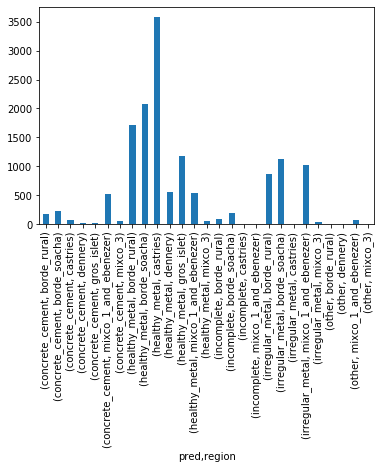

In [103]:
df.groupby(['pred','region']).size().plot(kind="bar")

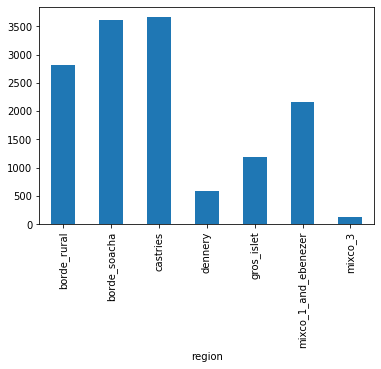

In [104]:
df.groupby(['region']).size().plot(kind="bar")

In [107]:
#TODO run without generating repeats
s = df['id'].str.split('_').apply(Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'is' # needs a name to join
df.join(s.apply(lambda x: Series(x.split('_'))))

,index,id,roof_material,verified,country,region,pred,model,loss,result,0
1,1,7a1f731e_256_bgconstant,irregular_metal,True,colombia,borde_rural,irregular_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.71,True,7a1f731e
1,1,7a1f731e_256_bgconstant,irregular_metal,True,colombia,borde_rural,irregular_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.71,True,256
1,1,7a1f731e_256_bgconstant,irregular_metal,True,colombia,borde_rural,irregular_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.71,True,bgconstant
5,5,7a1eb2bc_256_bgconstant,healthy_metal,True,colombia,borde_rural,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.03,True,7a1eb2bc
5,5,7a1eb2bc_256_bgconstant,healthy_metal,True,colombia,borde_rural,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.03,True,256
...,...,...,...,...,...,...,...,...,...,...,...
69825,22350,7a345068_zoom,healthy_metal,False,st_lucia,gros_islet,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.11,True,zoom
69845,22506,7a232c70_zoom,concrete_cement,True,st_lucia,castries,concrete_cement,03_28-0c79e3be_rz-s2-r0-20191201,0.09,True,7a232c70
69845,22506,7a232c70_zoom,concrete_cement,True,st_lucia,castries,concrete_cement,03_28-0c79e3be_rz-s2-r0-20191201,0.09,True,zoom
69847,22537,7a27186c_zoom,concrete_cement,True,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,1.33,False,7a27186c


In [109]:
df.head()

,index,id,roof_material,verified,country,region,pred,model,loss,result
18866,18866,7a1c5026_256_bgconstant,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.03,True
41405,18866,7a1c5026_256_reflect,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,True
63944,18866,7a1c5026_256_wrap,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.03,True
14217,14217,7a1c50f8_256_bgconstant,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,True
36756,14217,7a1c50f8_256_reflect,healthy_metal,False,st_lucia,castries,healthy_metal,03_28-0c79e3be_rz-s2-r0-20191201,0.02,True
